In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path("../../../")

In [3]:
mcnary_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_MCN.csv")
priest_rapids_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRD.csv")
prosser_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRO.csv")
ice_harbor_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_IHR.csv")

mcnary_df["date"] = pd.to_datetime(mcnary_df["date"])
priest_rapids_df["date"] = pd.to_datetime(priest_rapids_df["date"])
prosser_df["date"] = pd.to_datetime(prosser_df["date"])
ice_harbor_df["date"] = pd.to_datetime(ice_harbor_df["date"])

In [4]:
mcnary_df['year'] = mcnary_df['date'].dt.year
priest_rapids_df['year'] = priest_rapids_df['date'].dt.year
prosser_df['year'] = prosser_df['date'].dt.year
ice_harbor_df['year'] = ice_harbor_df['date'].dt.year

mcnary_df['month'] = mcnary_df['date'].dt.month
priest_rapids_df['month'] = priest_rapids_df['date'].dt.month
prosser_df['month'] = prosser_df['date'].dt.month
ice_harbor_df['month'] = ice_harbor_df['date'].dt.month

mcnary_df['day'] = mcnary_df['date'].dt.day
priest_rapids_df['day'] = priest_rapids_df['date'].dt.day
prosser_df['day'] = prosser_df['date'].dt.day
ice_harbor_df['day'] = ice_harbor_df['date'].dt.day

In [5]:
def migration_stats(df, date_col='date', fish_col='chinook', start_month=8, start_day=1, end_month=11, end_day=15):
    df[date_col] = pd.to_datetime(df[date_col])

    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day

    df = df.dropna(subset=[fish_col])

    # group bon_df by year and plot
    grouped = df.groupby('year')

    stats_df = pd.DataFrame(columns=['year', 'start_date', 'end_date', 'total_fish', 'daily_mean', 'max_count', '5th_percentile', '5th_date', '25th_percentile', '25th_date', '50th_percentile', '50th_date', '75th_percentile', '75th_date', '95th_percentile', '95th_date'])

    for name, group in grouped:
        stats_dict = {}
        run_start = pd.Timestamp(f"{name}-{start_month}-{start_day}")
        run_end = pd.Timestamp(f"{name}-{end_month}-{end_day}")

        run_df = group[(group[date_col] >= run_start) & (group[date_col] <= run_end)]
        run_df = run_df.sort_values(by=date_col) # sort run_df by date
        
        total_fish = run_df[fish_col].sum()
        # daily mean which is the total fish divided by the number of days from start to end
        daily_mean = total_fish / (run_end - run_start).days
        max_count = run_df[fish_col].max()


        stats_dict['year'] = name
        stats_dict['start_date'] = run_start
        stats_dict['end_date'] = run_end
        stats_dict['total_fish'] = total_fish
        stats_dict['daily_mean'] = daily_mean
        stats_dict['max_count'] = max_count

        # TODO: find a better way to calculate percentiles
        fish_sum = 0
        for i, row in run_df.iterrows():
            fish_sum += row[fish_col]
            
            if fish_sum >= total_fish * 0.05:
                stats_dict['5th_percentile'] = fish_sum
                stats_dict['5th_date'] = row[date_col]
                break

        fish_sum = 0

        for i, row in run_df.iterrows():
            fish_sum += row[fish_col]
            
            if fish_sum >= total_fish * 0.25:
                stats_dict['25th_percentile'] = fish_sum
                stats_dict['25th_date'] = row[date_col]
                break

        fish_sum = 0

        for i, row in run_df.iterrows():
            fish_sum += row[fish_col]
            
            if fish_sum >= total_fish * 0.50:
                stats_dict['50th_percentile'] = fish_sum
                stats_dict['50th_date'] = row[date_col]
                break

        fish_sum = 0

        for i, row in run_df.iterrows():
            fish_sum += row[fish_col]
            
            if fish_sum >= total_fish * 0.75:
                stats_dict['75th_percentile'] = fish_sum
                stats_dict['75th_date'] = row[date_col]
                break

        fish_sum = 0

        for i, row in run_df.iterrows():
            fish_sum += row[fish_col]
            
            if fish_sum >= total_fish * 0.95:
                stats_dict['95th_percentile'] = fish_sum
                stats_dict['95th_date'] = row[date_col]
                break

        stats_df = pd.concat([stats_df, pd.DataFrame(stats_dict, index=[0])])

    return stats_df
                



In [6]:
mcnary_stats_df = migration_stats(mcnary_df, start_month=8, start_day=9, end_month=10, end_day=31)
priest_rapids_stats_df = migration_stats(priest_rapids_df, start_month=8, start_day=14, end_month=11, end_day=15)
prosser_stats_df = migration_stats(prosser_df, start_month=8, start_day=16, end_month=12, end_day=28)
ice_harbor_stats_df = migration_stats(ice_harbor_df, start_month=8, start_day=12, end_month=12, end_day=15)

In [7]:
# filter out 2020 to 2023
mcnary_df_ = mcnary_df[(mcnary_df['date'].dt.year >= 2013) & (mcnary_df['date'].dt.year <= 2018)]
priest_rapids_df_ = priest_rapids_df[(priest_rapids_df['date'].dt.year >= 2013) & (priest_rapids_df['date'].dt.year <= 2018)]
prosser_df_ = prosser_df[(prosser_df['date'].dt.year >= 2013) & (prosser_df['date'].dt.year <= 2018)]
ice_harbor_df_ = ice_harbor_df[(ice_harbor_df['date'].dt.year >= 2013) & (ice_harbor_df['date'].dt.year <= 2018)]

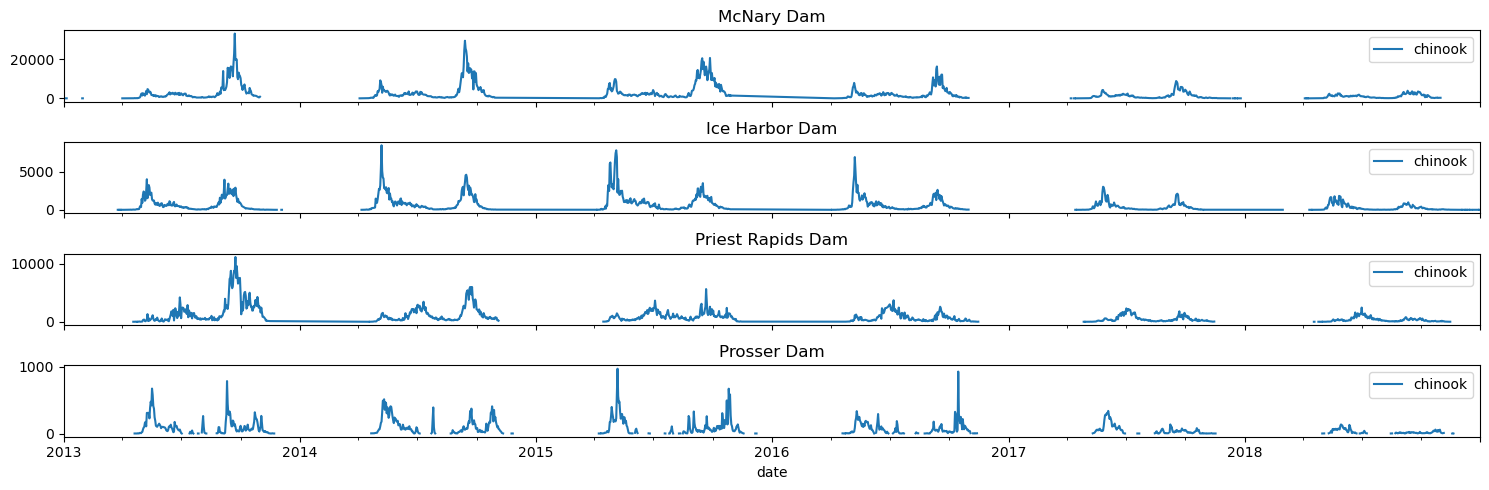

In [8]:
# fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15, 5), sharex=True)
fig, axs = plt.subplots(4, 1, figsize=(15, 5), sharex=True)
mcnary_df_.plot(x='date', y=['chinook'], style='-', ax=axs[0], title='McNary Dam')
ice_harbor_df_.plot(x='date', y=['chinook'], style='-', ax=axs[1], title='Ice Harbor Dam')
priest_rapids_df_.plot(x='date', y=['chinook'], style='-', ax=axs[2], title='Priest Rapids Dam')
prosser_df_.plot(x='date', y=['chinook'], style='-', ax=axs[3], title='Prosser Dam')

fig.tight_layout()

0
1
2
3


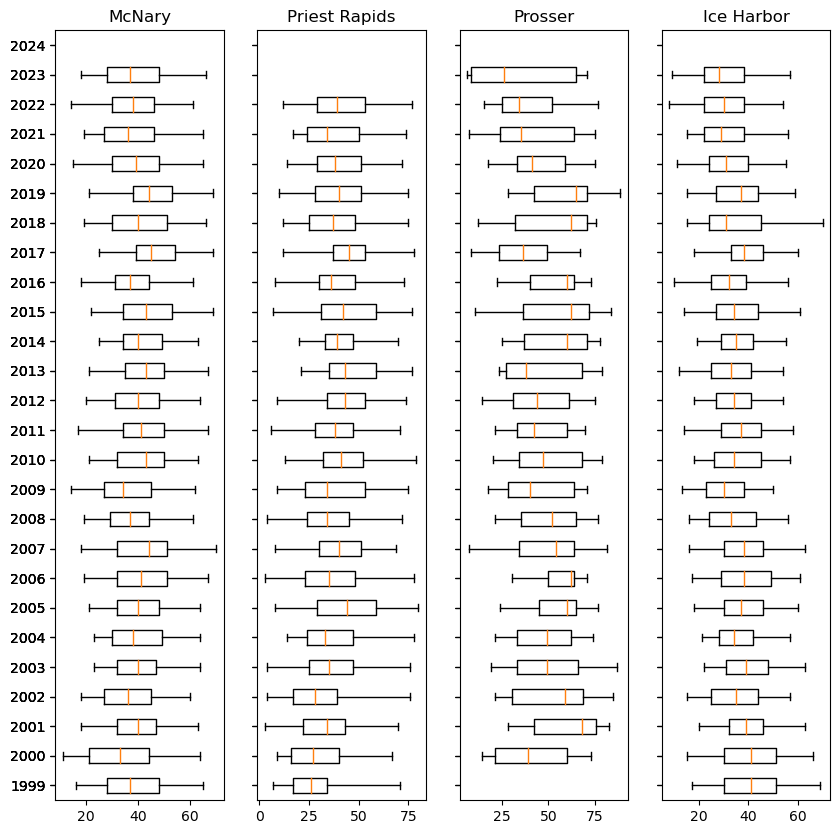

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(10, 10), sharey=True)
for i, (stats_df, loc) in enumerate(zip([mcnary_stats_df, priest_rapids_stats_df, prosser_stats_df, ice_harbor_stats_df], ['McNary', 'Priest Rapids', 'Prosser', 'Ice Harbor'])):
    print(i)
    boxes = []
    for j, row in stats_df.iterrows():
        
        boxes.append(
            {
                "label": f"{row['year']}",
                "whislo": (row['5th_date'] -row["start_date"]).days,  # Bottom whisker position
                "q1": (row['25th_date'] -row["start_date"]).days,  # First quartile (25th percentile)
                "med": (row['50th_date'] -row["start_date"]).days,  # Median         (50th percentile)
                "q3": (row['75th_date'] -row["start_date"]).days,  # Third quartile (75th percentile)
                "whishi": (row['95th_date'] -row["start_date"]).days,  # Top whisker position
                "fliers": [],  # Outliers
            }
        )

    axs[i].bxp(boxes, showfliers=False, vert=False)
    axs[i].set_title(loc)

Text(0, 0.5, 'Total fish count')

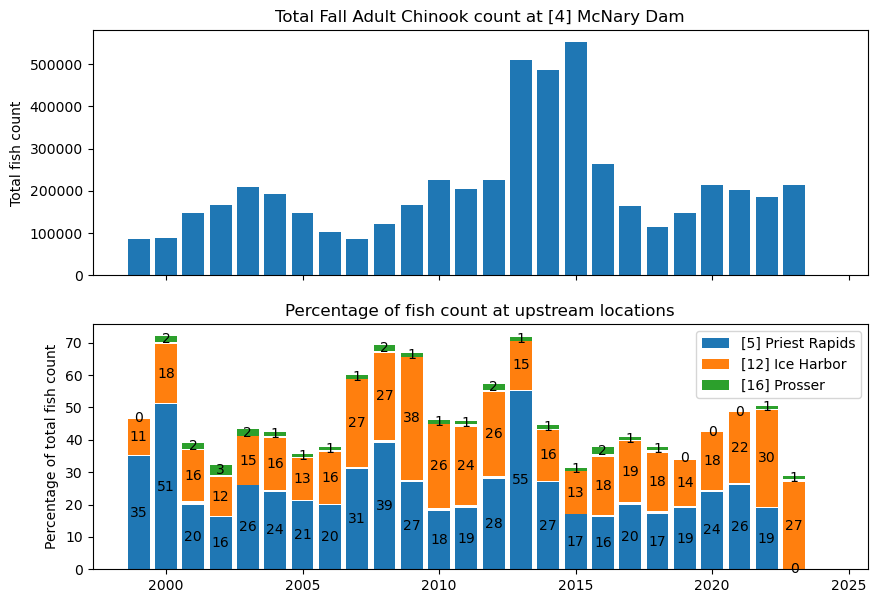

In [27]:
# stack bar plot of the total fish count except for McNary
data_dict = {
    "McNary": mcnary_stats_df[["year", "total_fish"]].copy(),
    "Priest Rapids": priest_rapids_stats_df[["year", "total_fish"]].copy(),
    "Prosser": prosser_stats_df[["year", "total_fish"]].copy(),
    "Ice Harbor": ice_harbor_stats_df[["year", "total_fish"]].copy(),
}

merged_data = pd.merge(
    data_dict["McNary"],
    data_dict["Priest Rapids"],
    on="year",
    how="outer",
    suffixes=("_1", "_2"),
)
merged_data = pd.merge(merged_data, data_dict["Prosser"], on="year", how="outer")
merged_data = pd.merge(
    merged_data, data_dict["Ice Harbor"], on="year", how="outer", suffixes=("_3", "_4")
)

# fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axs = axs[::-1]

locations = ["Priest Rapids", "Ice Harbor", "Prosser"]

percentages = {
    "Priest Rapids": merged_data["total_fish_2"] / merged_data["total_fish_1"] * 100,
    "Ice Harbor": merged_data["total_fish_4"] / merged_data["total_fish_1"] * 100,
    "Prosser": merged_data["total_fish_3"] / merged_data["total_fish_1"] * 100,
}

totals = {
    "Priest Rapids": merged_data["total_fish_2"],
    "Ice Harbor": merged_data["total_fish_4"],
    "Prosser": merged_data["total_fish_3"],
}

labels = {
    "Priest Rapids": "[5] Priest Rapids",
    "Ice Harbor": "[12] Ice Harbor",
    "Prosser": "[16] Prosser",
}

bottom = np.zeros(len(merged_data[:-1]))
bottom_totals = np.zeros(len(merged_data[:-1]))

for loc in locations:
    p = axs[0].bar(
        merged_data["year"][:-1].values.astype(int),
        percentages[loc][:-1].values.astype(int),
        label=labels[loc],
        bottom=bottom,
    )
    # axs[1].bar(merged_data['year'][:-1], totals[loc][:-1], label=loc, bottom=bottom_totals)
    bottom += percentages[loc][:-1]
    bottom_totals += totals[loc][:-1]

    axs[0].bar_label(p, label_type="center")

axs[0].set_title("Percentage of fish count at upstream locations")
# axs[1].set_title("Total fish count at each location")
axs[0].legend(loc="upper right")
axs[0].set_ylabel("Percentage of total fish count")

# axs[2].bar(merged_data['year'], merged_data['total_fish_1'], label='McNary')
axs[1].bar(merged_data["year"], merged_data["total_fish_1"], label="McNary")
axs[1].set_title("Total Fall Adult Chinook count at [4] McNary Dam")
axs[1].set_ylabel("Total fish count")

# axs[1].set_xlim(2013, 2018)


# species = (
#     "Adelie\n $\\mu=$3700.66g",
#     "Chinstrap\n $\\mu=$3733.09g",
#     "Gentoo\n $\\mu=5076.02g$",
# )
# weight_counts = {
#     "Below": np.array([70, 31, 58]),
#     "Above": np.array([82, 37, 66]),
# }
# width = 0.5

# fig, ax = plt.subplots()
# bottom = np.zeros(3)

# for boolean, weight_count in weight_counts.items():
#     p = axs[1].bar(species, weight_count, width, label=boolean, bottom=bottom)
#     bottom += weight_count

# axs[1].set_title("Number of penguins with above average body mass")
# axs[1].legend(loc="upper right")

In [172]:
col_510 = pd.read_csv(proj_dir / "Code/notebooks/EDA/columbia_510.csv")
col_520 = pd.read_csv(proj_dir / "Code/notebooks/EDA/columbia_520.csv")
col_470 = pd.read_csv(proj_dir / "Code/notebooks/EDA/columbia_470bw.csv")
col_630 = pd.read_csv(proj_dir / "Code/notebooks/EDA/columbia_630bw.csv")
sna_0 = pd.read_csv(proj_dir / "Code/notebooks/EDA/snake_0.csv")

col_510.rename(columns={"Date": "date", "WaterTemperature(C)": "col_510"}, inplace=True)
col_520.rename(columns={"Date": "date", "WaterTemperature(C)": "col_520"}, inplace=True)
col_470.rename(columns={"Date": "date", "WaterTemperature(C)": "col_470"}, inplace=True)
col_630.rename(columns={"Date": "date", "WaterTemperature(C)": "col_630"}, inplace=True)
sna_0.rename(columns={"Date": "date", "WaterTemperature(C)": "sna_0"}, inplace=True)

col_510['date'] = pd.to_datetime(col_510['date'])
col_520['date'] = pd.to_datetime(col_520['date'])
col_470['date'] = pd.to_datetime(col_470['date'])
col_630['date'] = pd.to_datetime(col_630['date'])
sna_0['date'] = pd.to_datetime(sna_0['date'])

col_510['year'] = col_510['date'].dt.year
col_520['year'] = col_520['date'].dt.year
col_470['year'] = col_470['date'].dt.year
col_630['year'] = col_630['date'].dt.year
sna_0['year'] = sna_0['date'].dt.year

col_510['month'] = col_510['date'].dt.month
col_520['month'] = col_520['date'].dt.month
col_470['month'] = col_470['date'].dt.month
col_630['month'] = col_630['date'].dt.month
sna_0['month'] = sna_0['date'].dt.month

col_510['day'] = col_510['date'].dt.day
col_520['day'] = col_520['date'].dt.day
col_470['day'] = col_470['date'].dt.day
col_630['day'] = col_630['date'].dt.day
sna_0['day'] = sna_0['date'].dt.day


In [174]:
col_470

,date,col_470,year,month,day
0,1983-01-29,3.22,1983,1,29
1,1983-08-13,20.97,1983,8,13
2,1984-04-08,9.00,1984,4,8
3,1984-04-22,11.15,1984,4,22
4,1984-05-06,12.23,1984,5,6
...,...,...,...,...,...
687,2024-02-26,4.90,2024,2,26
688,2024-03-11,5.89,2024,3,11
689,2024-03-25,7.45,2024,3,25
690,2024-04-08,9.43,2024,4,8


In [175]:
temp_df = pd.merge(col_510, col_520, on=['date', 'year', 'month', 'day'], how='outer')
temp_df = pd.merge(temp_df, col_470, on=['date', 'year', 'month', 'day'], how='outer')
temp_df = pd.merge(temp_df, col_630, on=['date', 'year', 'month', 'day'], how='outer')
temp_df = pd.merge(temp_df, sna_0, on=['date', 'year', 'month', 'day'], how='outer')
temp_df['week'] = temp_df['date'].dt.isocalendar().week

# temp_df = temp_df[(temp_df['date'].dt.year >= 2000) & (temp_df['date'].dt.year <= 2009)]
# temp_df = temp_df[(temp_df['date'].dt.year == 2000) | (temp_df['date'].dt.year == 2001) | (temp_df['date'].dt.year == 2002) | (temp_df['date'].dt.year == 2003) | (temp_df['date'].dt.year == 2004) | (temp_df['date'].dt.year == 2005) | (temp_df['date'].dt.year == 2006) | (temp_df['date'].dt.year == 2007) | (temp_df['date'].dt.year == 2008) | (temp_df['date'].dt.year == 2009)]
temp_df = temp_df[(temp_df['date'].dt.year == 2000) | (temp_df['date'].dt.year == 2002) | (temp_df['date'].dt.year == 2008) | (temp_df['date'].dt.year == 2009) | (temp_df['date'].dt.year == 2014) | (temp_df['date'].dt.year == 2013) | (temp_df['date'].dt.year == 2015)]


# filter out june to october

temp_df = temp_df[(temp_df['month'] >= 6) & (temp_df['month'] <= 10)]
# temp_df['diff'] = temp_df['col_510'] - temp_df['sna_0']
temp_df['diff'] = temp_df['col_470'] - temp_df['col_630']

In [159]:
# fig, ax = plt.subplots(figsize=(15, 5))
# temp_df.plot(x='date', y=['col_510', 'sna_0'], style='-', title='Water temperature at different locations', ax=ax)

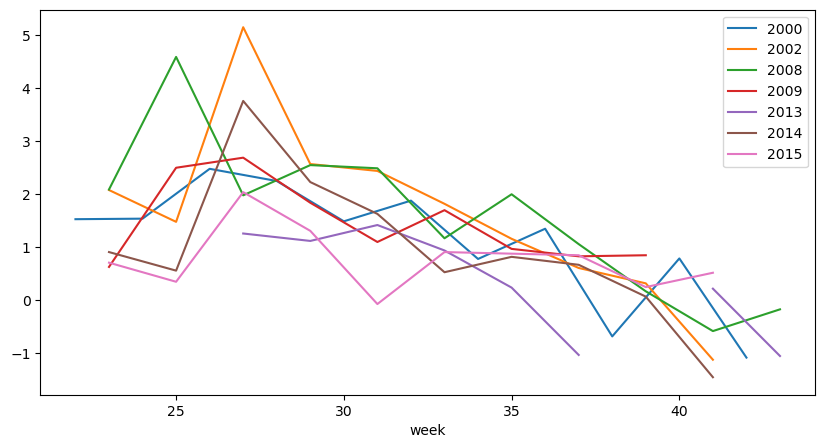

In [176]:
fall_grouped = temp_df.groupby('year')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name, group in fall_grouped:
    group.plot(x='week', y='diff', ax=ax, label=name)
    # group.plot(x='week', y='col_510', ax=ax[1], label=f"{name} col_510")
    # group.plot(x='week', y='sna_0', ax=ax[1], label=f"{name} sna_0")

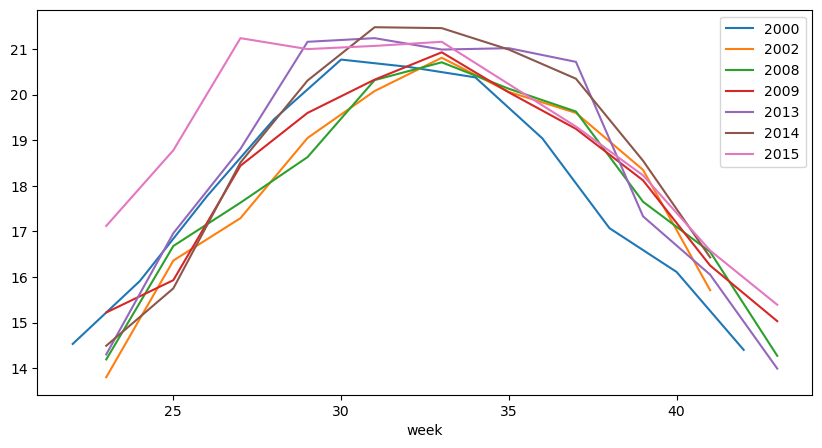

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name, group in fall_grouped:
    group.plot(x='week', y='sna_0', ax=ax, label=name)

In [47]:
def time_analysis(stats_df1, stats_df2,):
    # merge the two dataframes on year
    merged_df = pd.merge(stats_df1, stats_df2, on='year', suffixes=('_1', '_2'), how='inner')

    time_analysis_df = pd.DataFrame()

    # calculate the difference between the two start dates
    time_analysis_df['year'] = merged_df['year']
    time_analysis_df['start_date_diff'] = (merged_df['start_date_2'] - merged_df['start_date_1']).dt.days
    time_analysis_df['end_date_diff'] = (merged_df['end_date_2'] - merged_df['end_date_1']).dt.days
    time_analysis_df['total_fish_diff'] = merged_df['total_fish_2'] - merged_df['total_fish_1']
    time_analysis_df['5th_date_diff'] = (merged_df['5th_date_2'] - merged_df['5th_date_1']).dt.days
    time_analysis_df['25th_date_diff'] = (merged_df['25th_date_2'] - merged_df['25th_date_1']).dt.days
    time_analysis_df['50th_date_diff'] = (merged_df['50th_date_2'] - merged_df['50th_date_1']).dt.days
    time_analysis_df['75th_date_diff'] = (merged_df['75th_date_2'] - merged_df['75th_date_1']).dt.days
    time_analysis_df['95th_date_diff'] = (merged_df['95th_date_2'] - merged_df['95th_date_1']).dt.days

    return time_analysis_df

In [56]:
priest_rapids_stats_df

,year,start_date,end_date,total_fish,daily_mean,max_count,5th_percentile,5th_date,25th_percentile,25th_date,50th_percentile,50th_date,75th_percentile,75th_date,95th_percentile,95th_date
0,1999,1999-08-14,1999-11-15,30729.0,330.419355,1730.0,1559.0,1999-08-21,8089.0,1999-08-31,15538.0,1999-09-09,23279.0,1999-09-17,29379.0,1999-10-24
0,2000,2000-08-14,2000-11-15,45223.0,486.268817,2936.0,2794.0,2000-08-23,11394.0,2000-08-30,23229.0,2000-09-10,33937.0,2000-09-23,43129.0,2000-10-20
0,2001,2001-08-14,2001-11-15,30757.0,330.720430,1373.0,1551.0,2001-08-17,7781.0,2001-09-05,16364.0,2001-09-17,23304.0,2001-09-26,29245.0,2001-10-23
0,2002,2002-08-14,2002-11-15,27366.0,294.258065,1573.0,1769.0,2002-08-18,7212.0,2002-08-31,13725.0,2002-09-11,20917.0,2002-09-22,26081.0,2002-10-29
0,2003,2003-08-14,2003-11-15,54453.0,585.516129,2210.0,2888.0,2003-08-18,14574.0,2003-09-08,28311.0,2003-09-18,41681.0,2003-09-30,52396.0,2003-10-29
0,2004,2004-08-14,2004-11-15,47406.0,509.741935,2209.0,2454.0,2004-08-28,11852.0,2004-09-07,24253.0,2004-09-16,36187.0,2004-09-30,45161.0,2004-10-31
0,2005,2005-08-14,2005-11-15,31641.0,340.225806,1361.0,1652.0,2005-08-22,8268.0,2005-09-12,16015.0,2005-09-27,24219.0,2005-10-12,30292.0,2005-11-02
0,2006,2006-08-14,2006-11-15,20678.0,222.344086,798.0,1156.0,2006-08-17,5193.0,2006-09-06,10776.0,2006-09-18,15730.0,2006-10-01,19726.0,2006-10-31
0,2007,2007-08-14,2007-11-15,27033.0,290.677419,974.0,1425.0,2007-08-22,7178.0,2007-09-13,14317.0,2007-09-23,20445.0,2007-10-04,25688.0,2007-10-22
0,2008,2008-08-14,2008-11-15,48586.0,522.430108,1747.0,2630.0,2008-08-18,12984.0,2008-09-07,24785.0,2008-09-17,37248.0,2008-09-28,46213.0,2008-10-25


In [57]:
mcnary_stats_df

,year,start_date,end_date,total_fish,daily_mean,max_count,5th_percentile,5th_date,25th_percentile,25th_date,50th_percentile,50th_date,75th_percentile,75th_date,95th_percentile,95th_date
0,1999,1999-08-09,1999-10-31,87096.0,1049.349398,3107.0,4506.0,1999-08-25,21980.0,1999-09-06,44213.0,1999-09-15,65646.0,1999-09-26,83122.0,1999-10-13
0,2000,2000-08-09,2000-10-31,87891.0,1058.927711,3640.0,4816.0,2000-08-20,23546.0,2000-08-30,46921.0,2000-09-11,66221.0,2000-09-22,83695.0,2000-10-12
0,2001,2001-08-09,2001-10-31,146898.0,1769.855422,6521.0,7899.0,2001-08-27,36797.0,2001-09-10,79273.0,2001-09-18,110567.0,2001-09-25,139731.0,2001-10-11
0,2002,2002-08-09,2002-10-31,167114.0,2013.421687,8258.0,9943.0,2002-08-27,43780.0,2002-09-05,83742.0,2002-09-14,125597.0,2002-09-23,158937.0,2002-10-08
0,2003,2003-08-09,2003-10-31,208982.0,2517.855422,10660.0,12552.0,2003-09-01,55539.0,2003-09-10,108906.0,2003-09-18,159214.0,2003-09-25,199054.0,2003-10-12
0,2004,2004-08-09,2004-10-31,193140.0,2326.987952,9657.0,12818.0,2004-09-01,48483.0,2004-09-08,100305.0,2004-09-16,149682.0,2004-09-27,184142.0,2004-10-12
0,2005,2005-08-09,2005-10-31,147189.0,1773.361446,8289.0,8270.0,2005-08-30,38849.0,2005-09-10,77499.0,2005-09-18,110528.0,2005-09-26,140312.0,2005-10-12
0,2006,2006-08-09,2006-10-31,102863.0,1239.313253,5052.0,5435.0,2006-08-28,26824.0,2006-09-10,52125.0,2006-09-19,77654.0,2006-09-29,97833.0,2006-10-15
0,2007,2007-08-09,2007-10-31,85262.0,1027.253012,4362.0,4764.0,2007-08-27,21579.0,2007-09-10,43023.0,2007-09-22,64921.0,2007-09-29,81694.0,2007-10-18
0,2008,2008-08-09,2008-10-31,121792.0,1467.373494,5364.0,6910.0,2008-08-28,31482.0,2008-09-07,64067.0,2008-09-15,92149.0,2008-09-22,116211.0,2008-10-09


In [52]:
priest_rapids_ta = time_analysis(mcnary_stats_df, priest_rapids_stats_df)
prosser_ta = time_analysis(mcnary_stats_df, prosser_stats_df)
ice_harbor_ta = time_analysis(mcnary_stats_df, ice_harbor_stats_df)

<Axes: xlabel='year'>

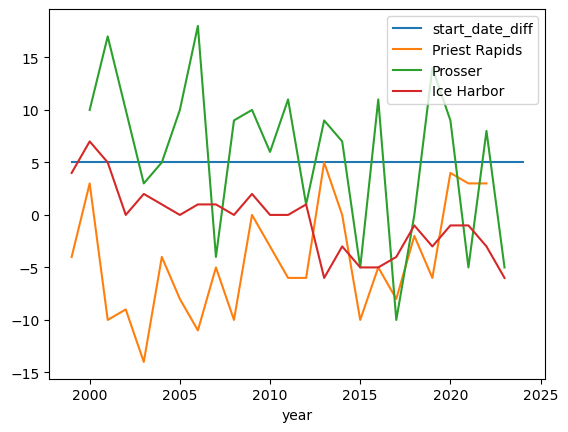

In [58]:
fig, ax = plt.subplots()
priest_rapids_ta.plot(x='year', y='start_date_diff', ax=ax,)
priest_rapids_ta.plot(x='year', y='5th_date_diff', ax=ax, label='Priest Rapids')
prosser_ta.plot(x='year', y='5th_date_diff', ax=ax, label='Prosser')
ice_harbor_ta.plot(x='year', y='5th_date_diff', ax=ax, label='Ice Harbor')


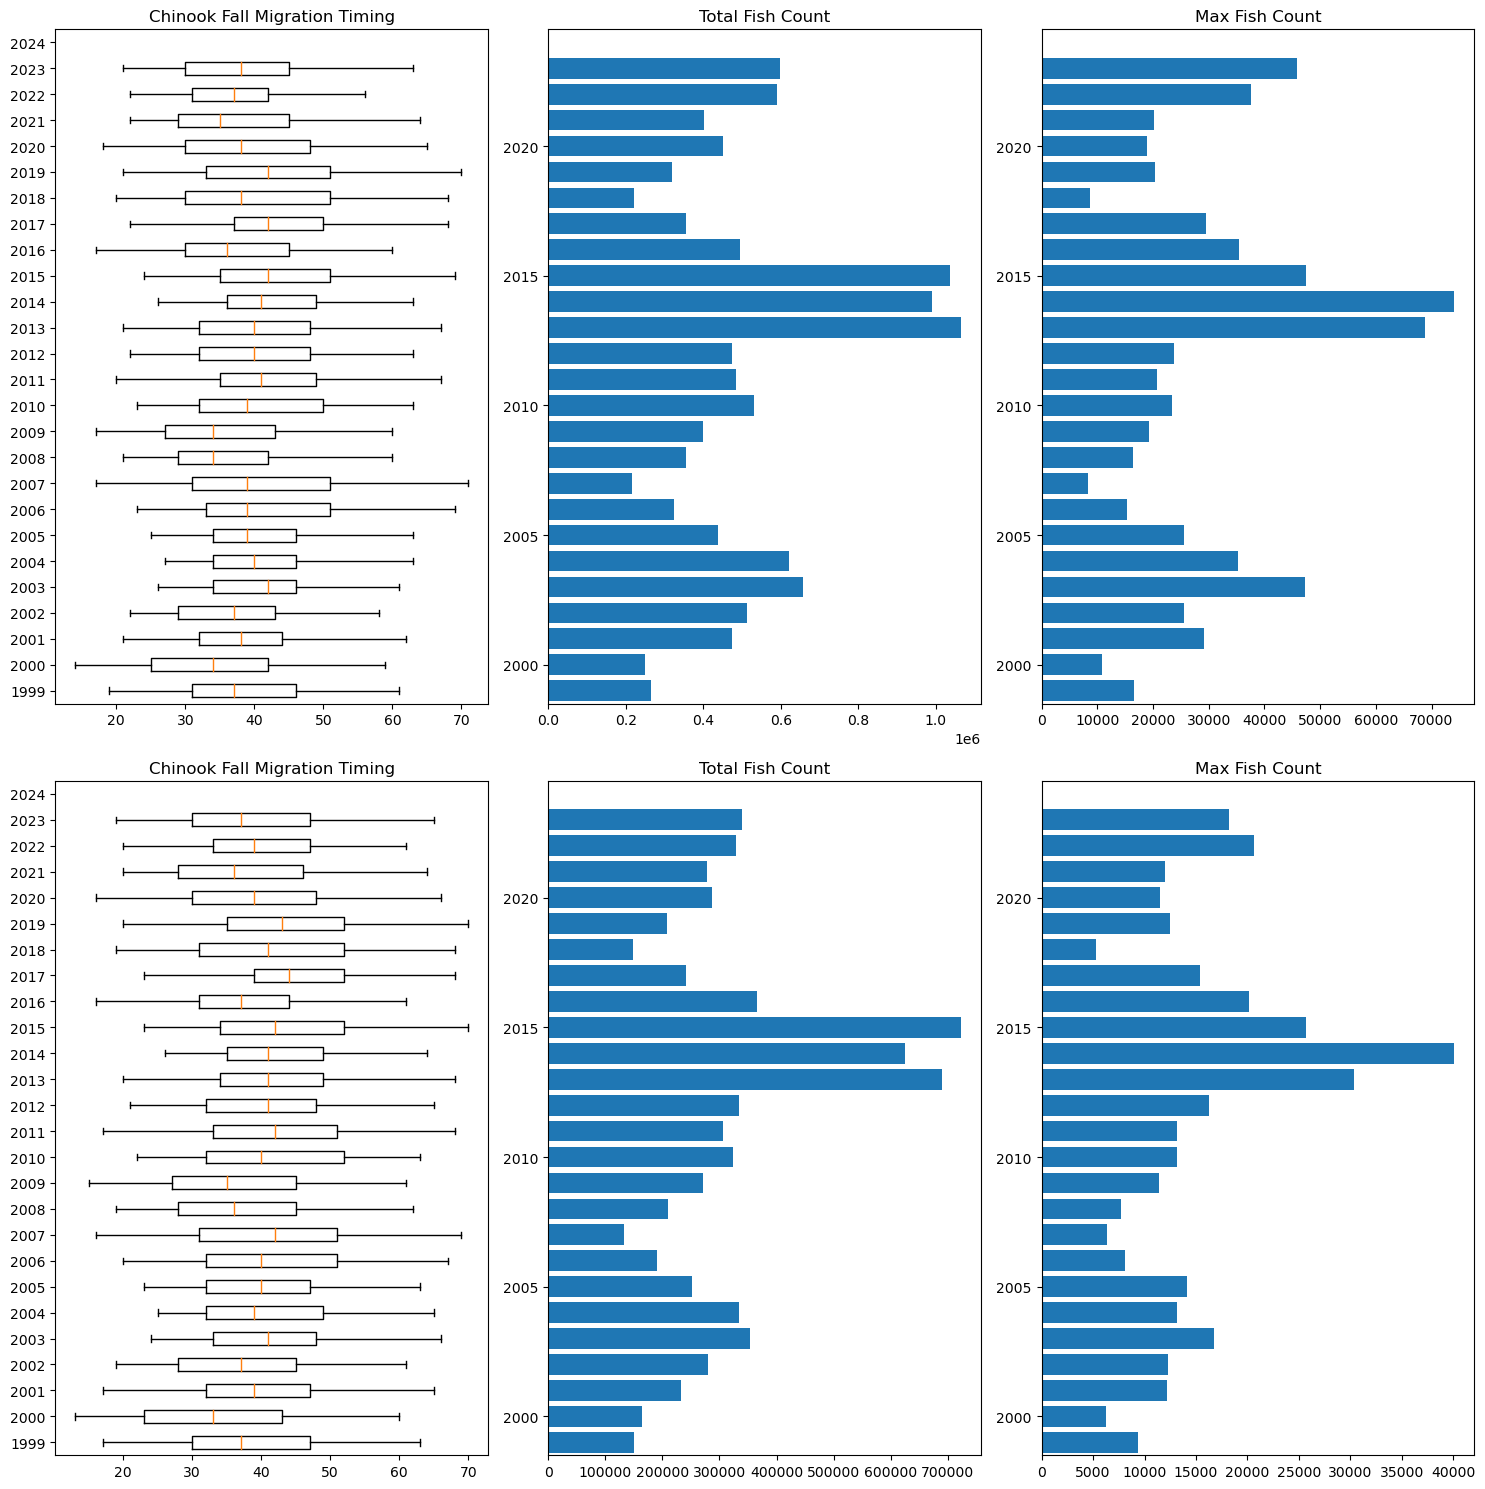

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
axs = axs.flatten()

boxes = []
for i, row in bon_stats_df.iterrows():
    
    boxes.append(
        {
            "label": f"{row['year']}",
            "whislo": (row['5th_date'] -row["start_date"]).days,  # Bottom whisker position
            "q1": (row['25th_date'] -row["start_date"]).days,  # First quartile (25th percentile)
            "med": (row['50th_date'] -row["start_date"]).days,  # Median         (50th percentile)
            "q3": (row['75th_date'] -row["start_date"]).days,  # Third quartile (75th percentile)
            "whishi": (row['95th_date'] -row["start_date"]).days,  # Top whisker position
            "fliers": [],  # Outliers
        }
    )

axs[0].bxp(boxes, showfliers=False, vert=False);
axs[0].set_title("Chinook Fall Migration Timing")

# plot total fish count
axs[1].barh(bon_stats_df['year'], bon_stats_df['total_fish'])
axs[1].set_title("Total Fish Count")
axs[1].set_ylim(1998.5, 2024.5)

# plot max count
axs[2].barh(bon_stats_df['year'], bon_stats_df['max_count'])
axs[2].set_title("Max Fish Count")
axs[2].set_ylim(1998.5, 2024.5)

boxes = []
for i, row in tda_stats_df.iterrows():
    
    boxes.append(
        {
            "label": f"{row['year']}",
            "whislo": (row['5th_date'] -row["start_date"]).days,  # Bottom whisker position
            "q1": (row['25th_date'] -row["start_date"]).days,  # First quartile (25th percentile)
            "med": (row['50th_date'] -row["start_date"]).days,  # Median         (50th percentile)
            "q3": (row['75th_date'] -row["start_date"]).days,  # Third quartile (75th percentile)
            "whishi": (row['95th_date'] -row["start_date"]).days,  # Top whisker position
            "fliers": [],  # Outliers
        }
    )

axs[3].bxp(boxes, showfliers=False, vert=False);
axs[3].set_title("Chinook Fall Migration Timing")

# plot total fish count
axs[4].barh(tda_stats_df['year'], tda_stats_df['total_fish'])
axs[4].set_title("Total Fish Count")
axs[4].set_ylim(1998.5, 2024.5)

# plot max count
axs[5].barh(tda_stats_df['year'], tda_stats_df['max_count'])
axs[5].set_title("Max Fish Count")
axs[5].set_ylim(1998.5, 2024.5)

fig.tight_layout()


In [18]:
bon_tda_temp = pd.read_csv(proj_dir / "Code/notebooks/EDA/bon-tda.csv")
bon_tda_temp['date'] = pd.to_datetime(bon_tda_temp['Date'])
bon_tda_temp = bon_tda_temp[bon_tda_temp['date'].dt.year >= 1999].copy()

bon_tda_temp['year'] = bon_tda_temp['date'].dt.year
bon_tda_temp['month'] = bon_tda_temp['date'].dt.month
bon_tda_temp['day'] = bon_tda_temp['date'].dt.day

fish_dif = bon_stats_df['total_fish'] - tda_stats_df['total_fish']
fish_dif_percent = (bon_stats_df['total_fish'] - tda_stats_df['total_fish']) / bon_stats_df['total_fish'] * 100

lyl_percent = lyl_stats_df['total_fish'] / bon_stats_df['total_fish'] * 100

In [23]:
# lyl_stats_df.plot(x='year', y='total_fish', style='-')
lyl_stats_df

,year,start_date,end_date,total_fish,daily_mean,max_count,5th_percentile,5th_date,25th_percentile,25th_date,50th_percentile,50th_date,75th_percentile,75th_date,95th_percentile,95th_date,duration
0,2007,2007-08-01,2007-11-15,72.0,0.679245,26.0,5.0,2007-08-31,42.0,2007-10-02,42.0,2007-10-02,58.0,2007-10-09,72.0,2007-10-17,47.0
0,2008,2008-08-01,2008-11-15,24.0,0.226415,6.0,2.0,2008-08-08,11.0,2008-08-20,14.0,2008-08-26,19.0,2008-09-17,24.0,2008-10-17,70.0
0,2009,2009-08-01,2009-11-15,17.0,0.160377,4.0,2.0,2009-08-05,5.0,2009-09-04,9.0,2009-09-23,13.0,2009-09-30,17.0,2009-10-18,74.0
0,2010,2010-08-01,2010-11-15,65.0,0.613208,36.0,5.0,2010-08-11,26.0,2010-09-02,65.0,2010-09-07,65.0,2010-09-07,65.0,2010-09-07,27.0
0,2011,2011-08-01,2011-11-15,1424.0,13.433962,210.0,75.0,2011-09-02,421.0,2011-09-20,828.0,2011-09-23,1133.0,2011-09-28,1375.0,2011-09-30,28.0
0,2012,2012-08-01,2012-11-15,985.0,9.292453,445.0,75.0,2012-09-07,336.0,2012-09-12,799.0,2012-09-18,799.0,2012-09-18,937.0,2012-10-11,34.0
0,2013,2013-08-01,2013-11-15,3862.0,36.433962,795.0,223.0,2013-08-30,1268.0,2013-09-10,2063.0,2013-09-11,2985.0,2013-09-19,3683.0,2013-10-24,55.0
0,2014,2014-08-01,2014-11-15,3097.0,29.216981,417.0,502.0,2014-09-10,919.0,2014-09-11,1694.0,2014-09-17,2379.0,2014-09-23,2978.0,2014-10-02,22.0
0,2015,2015-08-01,2015-11-15,1830.0,17.264151,731.0,127.0,2015-09-01,539.0,2015-09-03,1385.0,2015-09-11,1385.0,2015-09-11,1753.0,2015-10-14,43.0
0,2016,2016-08-01,2016-11-15,154.0,1.452830,42.0,9.0,2016-08-31,72.0,2016-09-09,81.0,2016-09-20,116.0,2016-09-29,150.0,2016-11-01,62.0


In [ ]:
# lyl_stats_df.plot(x='year', y='total_fish', style='-')
lyl_stats_df

,year,start_date,end_date,total_fish,daily_mean,max_count,5th_percentile,5th_date,25th_percentile,25th_date,50th_percentile,50th_date,75th_percentile,75th_date,95th_percentile,95th_date,duration
0,2007,2007-08-01,2007-11-15,72.0,0.679245,26.0,5.0,2007-08-31,42.0,2007-10-02,42.0,2007-10-02,58.0,2007-10-09,72.0,2007-10-17,47.0
0,2008,2008-08-01,2008-11-15,24.0,0.226415,6.0,2.0,2008-08-08,11.0,2008-08-20,14.0,2008-08-26,19.0,2008-09-17,24.0,2008-10-17,70.0
0,2009,2009-08-01,2009-11-15,17.0,0.160377,4.0,2.0,2009-08-05,5.0,2009-09-04,9.0,2009-09-23,13.0,2009-09-30,17.0,2009-10-18,74.0
0,2010,2010-08-01,2010-11-15,65.0,0.613208,36.0,5.0,2010-08-11,26.0,2010-09-02,65.0,2010-09-07,65.0,2010-09-07,65.0,2010-09-07,27.0
0,2011,2011-08-01,2011-11-15,1424.0,13.433962,210.0,75.0,2011-09-02,421.0,2011-09-20,828.0,2011-09-23,1133.0,2011-09-28,1375.0,2011-09-30,28.0
0,2012,2012-08-01,2012-11-15,985.0,9.292453,445.0,75.0,2012-09-07,336.0,2012-09-12,799.0,2012-09-18,799.0,2012-09-18,937.0,2012-10-11,34.0
0,2013,2013-08-01,2013-11-15,3862.0,36.433962,795.0,223.0,2013-08-30,1268.0,2013-09-10,2063.0,2013-09-11,2985.0,2013-09-19,3683.0,2013-10-24,55.0
0,2014,2014-08-01,2014-11-15,3097.0,29.216981,417.0,502.0,2014-09-10,919.0,2014-09-11,1694.0,2014-09-17,2379.0,2014-09-23,2978.0,2014-10-02,22.0
0,2015,2015-08-01,2015-11-15,1830.0,17.264151,731.0,127.0,2015-09-01,539.0,2015-09-03,1385.0,2015-09-11,1385.0,2015-09-11,1753.0,2015-10-14,43.0
0,2016,2016-08-01,2016-11-15,154.0,1.452830,42.0,9.0,2016-08-31,72.0,2016-09-09,81.0,2016-09-20,116.0,2016-09-29,150.0,2016-11-01,62.0


In [61]:
grouped_temp = bon_tda_temp.groupby('year')

In [62]:
grouped_temp['year'].unique()

year
1999    [1999]
2000    [2000]
2001    [2001]
2002    [2002]
2003    [2003]
2004    [2004]
2005    [2005]
2006    [2006]
2007    [2007]
2008    [2008]
2009    [2009]
2010    [2010]
2011    [2011]
2012    [2012]
2013    [2013]
2014    [2014]
2015    [2015]
2016    [2016]
2017    [2017]
2018    [2018]
2019    [2019]
2020    [2020]
2021    [2021]
2022    [2022]
2023    [2023]
2024    [2024]
Name: year, dtype: object

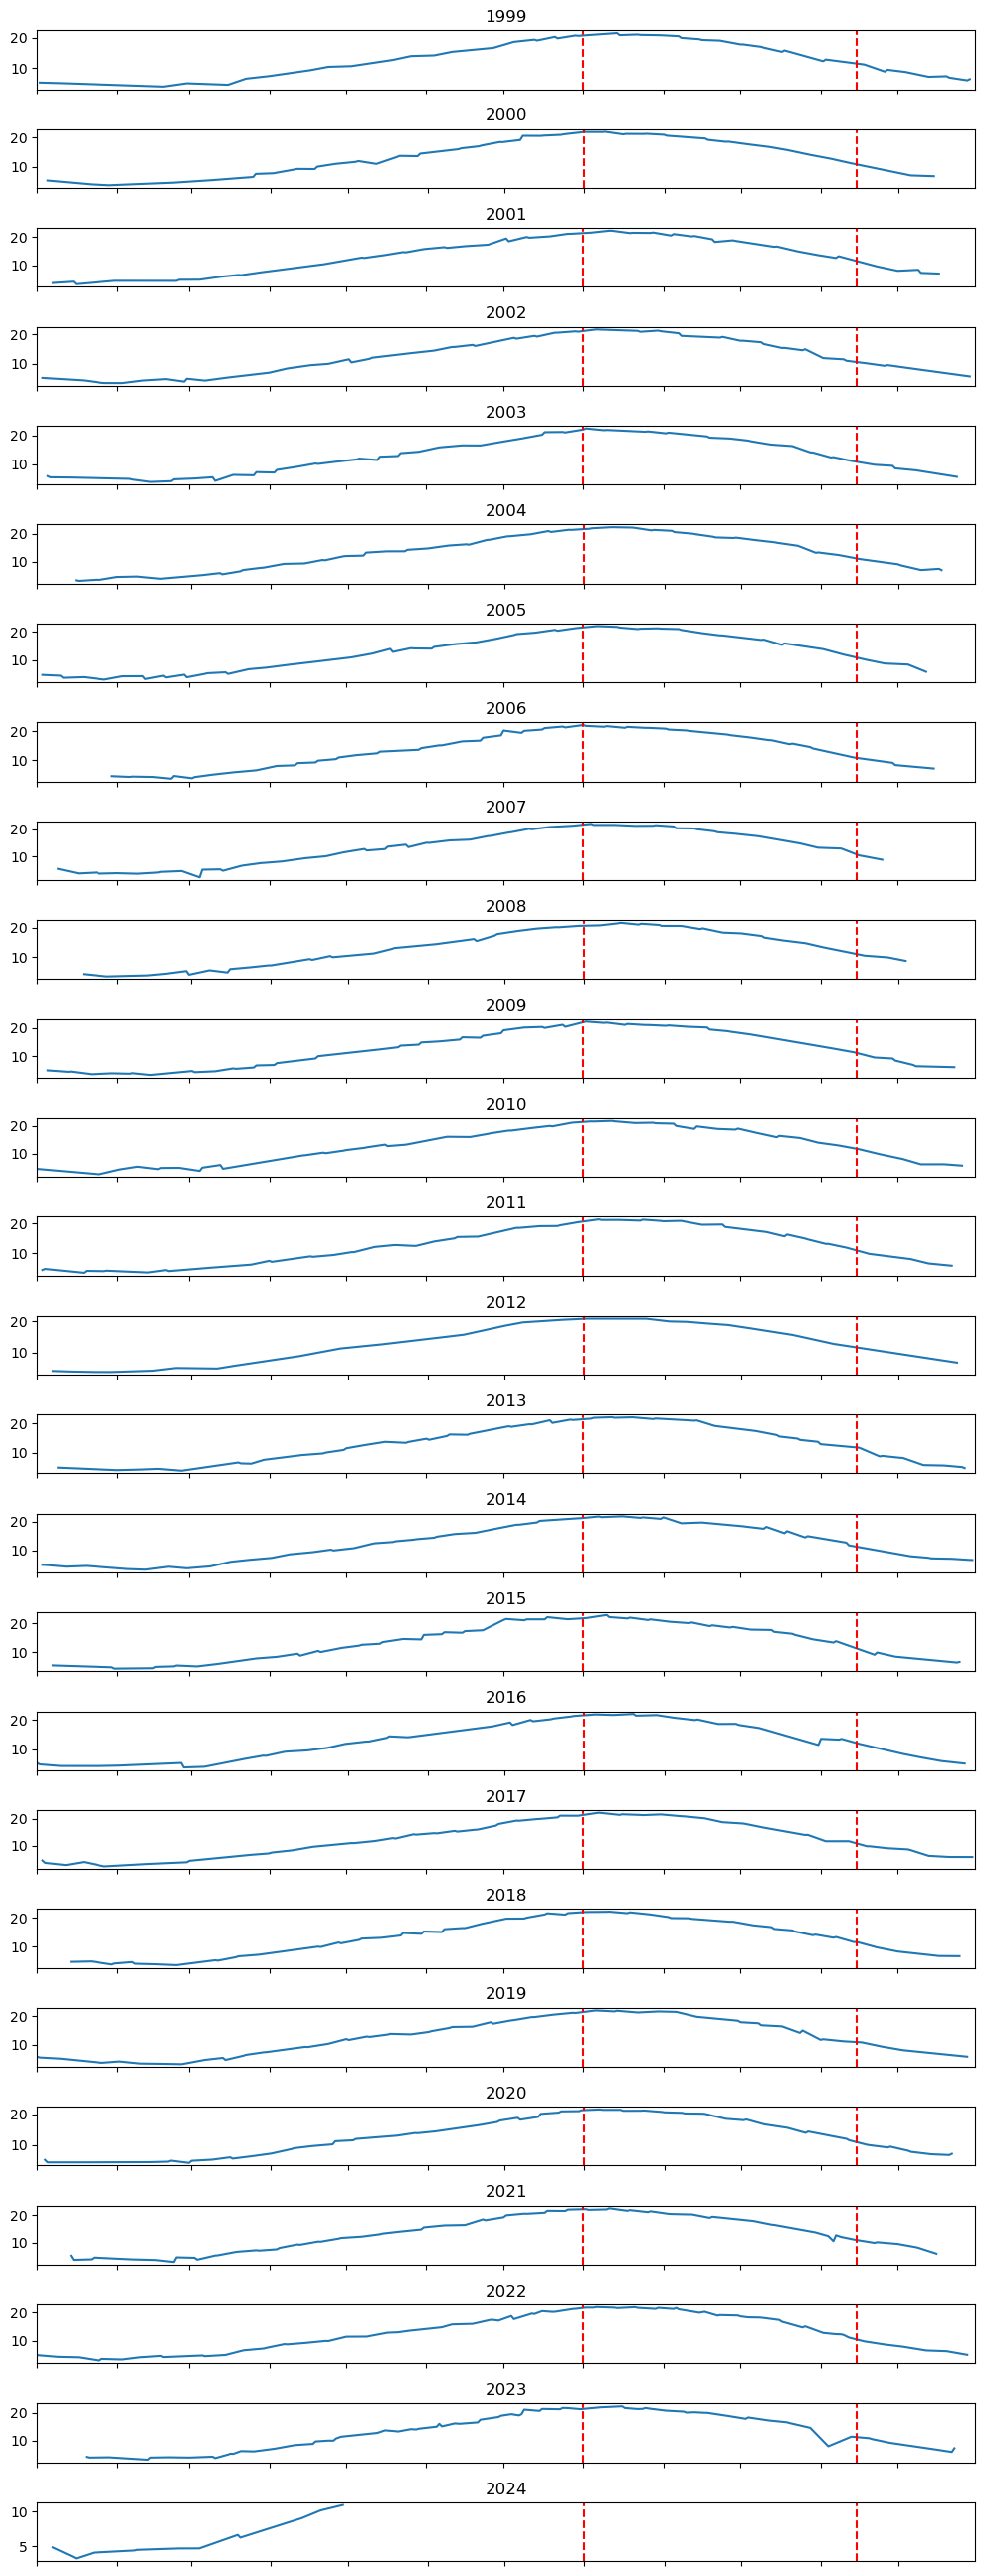

In [63]:
# for each year, plot the temperature from August 1 to November 15
fig, axs = plt.subplots(len(grouped_temp['year'].unique()), 1, figsize=(10, 1*len(grouped_temp['year'].unique())))

for i, (name, group) in enumerate(grouped_temp):
    axs[i].plot(group['date'], group['AvgTemp'])
    axs[i].set_title(name)
    axs[i].axvline(pd.Timestamp(f"{name}-{fall_start_month}-{fall_start_day}"), color='r', linestyle='--')
    axs[i].axvline(pd.Timestamp(f"{name}-{fall_end_month}-{fall_end_day}"), color='r', linestyle='--')

    axs[i].set_xlim(pd.Timestamp(f"{name}-01-01"), pd.Timestamp(f"{name}-12-31"))

    # remove x-axis labels
    axs[i].set_xticklabels([])

fig.tight_layout()

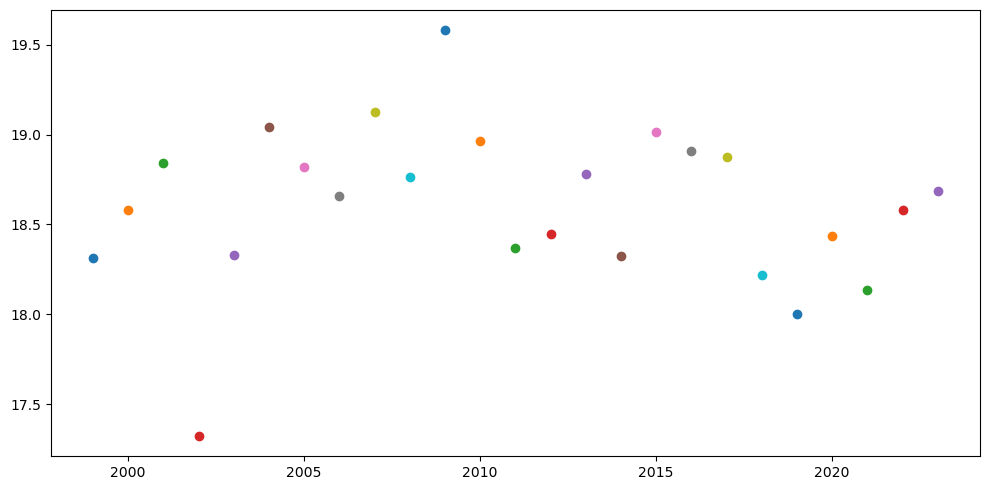

In [66]:
# for each year, plot the temperature from August 1 to November 15
fig, ax = plt.subplots(figsize=(10, 5))

years = []
mean_fall_temp = []

for i, (name, group) in enumerate(grouped_temp):

    group['date'] = pd.to_datetime(group['date'])
    group = group[(group['date']>f"{name}-{fall_start_month}-{fall_start_day}") & (group['date']<f"{name}-{fall_end_month}-{fall_end_day}")].copy()
    group['year'] = group['date'].dt.year
    group['month'] = group['date'].dt.month 
    group['day'] = group['date'].dt.day

    group['time_elapsed'] = (group['date'] - pd.Timestamp(f"{name}-{fall_start_month}-{fall_start_day}")).dt.days

    if not group.empty:
        ax.scatter(name, group['AvgTemp'].mean(), label=name)
        years.append(name)
        mean_fall_temp.append(group['AvgTemp'].mean())

        # print(group)

    # # create a new date column that is this_year-month-day
    # group['modified_date'] = pd.to_datetime(f"2020-{group['month']}-{group['day']}")
    # ax.plot(group['modified_date'], group['AvgTemp'], label=name)



    # # ax.axvline(pd.Timestamp(f"{name}-{fall_start_month}-{fall_start_day}"), color='r', linestyle='--')
    # # ax.axvline(pd.Timestamp(f"{name}-{fall_end_month}-{fall_end_day}"), color='r', linestyle='--')

    # # ax.set_xlim(pd.Timestamp(f"{name}-01-01"), pd.Timestamp(f"{name}-12-31"))

    # # remove x-axis labels
    # ax.set_xticklabels([])

fig.tight_layout()

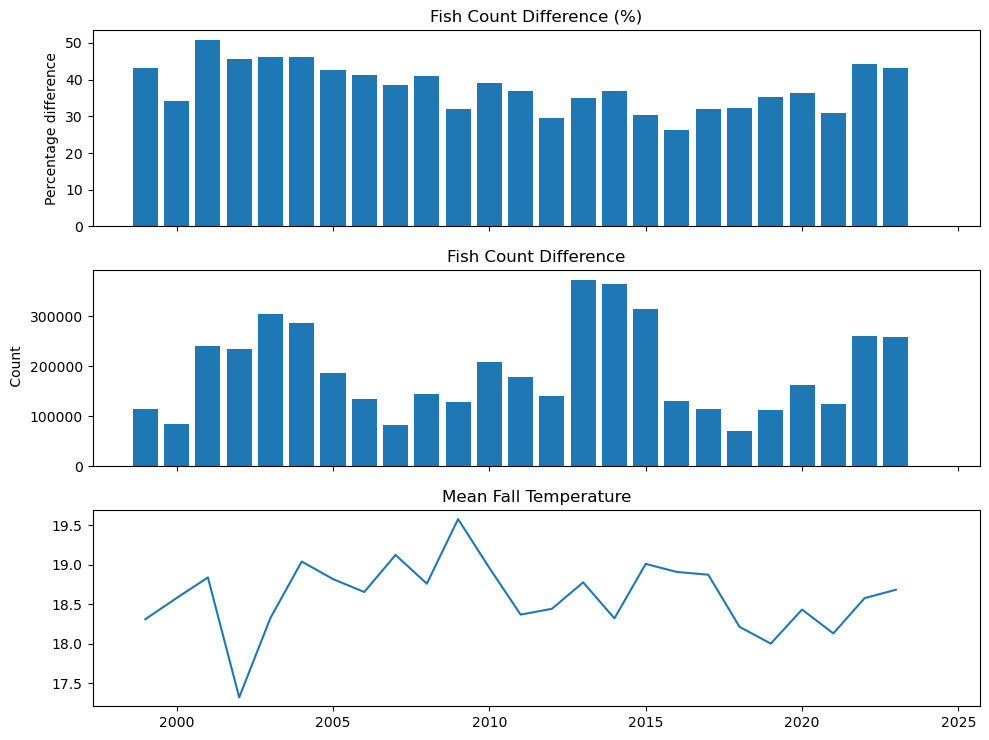

In [74]:
# plot the fish count difference between BON and TDA
fig, axs = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)
axs[0].bar(bon_stats_df['year'], fish_dif_percent)
axs[0].set_title("Fish Count Difference (%)")
axs[0].set_ylabel("Percentage difference")

axs[1].bar(bon_stats_df['year'], fish_dif)
axs[1].set_title("Fish Count Difference")
axs[1].set_ylabel(" Count")

axs[2].plot(years, mean_fall_temp)
axs[2].set_title("Mean Fall Temperature")

fig.tight_layout()

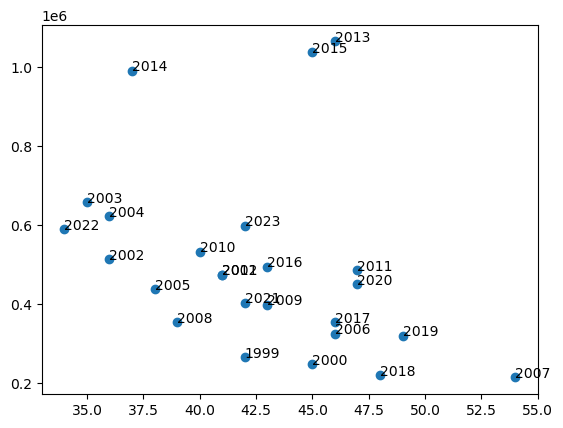

In [21]:
fig, ax = plt.subplots()
# plot duration and total fish annotated with the duration
ax.scatter(stats_df['duration'], stats_df['total_fish'])
for i, row in stats_df.iterrows():
    ax.annotate(row['year'], (row['duration'], row['total_fish']))

# ax.scatter(stats_df['duration'], stats_df['max_count'], color='r')
# ax.scatter((stats_df['5th_date'] -stats_df["start_date"]).dt.days, stats_df['total_fish'], color='b')
# ax.set_ylim(0, .8e6)


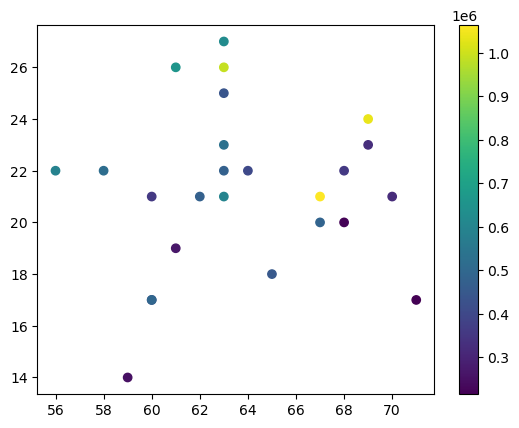

In [58]:
fig, ax = plt.subplots()
# plot duration and total fish annotated with the duration
# ax.scatter(stats_df['duration'], stats_df['total_fish'])
# for i, row in stats_df.iterrows():
#     ax.annotate(row['duration'], (row['duration'], row['total_fish']))

# ax.scatter(stats_df['duration'], stats_df['max_count'], color='r')
m = ax.scatter((stats_df['95th_date'] -stats_df["start_date"]).dt.days,(stats_df['5th_date'] -stats_df["start_date"]).dt.days, c=stats_df['total_fish'])
# add colorbar
cbar = fig.colorbar(m)
